In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import preproc as pp

import tensorflow as tf

augp = Path("../scratch").joinpath("train_augmented")
modelp = Path("../scratch").joinpath("models")

train_ir, test_ir = pp.load_data(val_size=0)
train_aug, test_aug = pp.load_aug_data(augp, train_ir.element_spec, test_ind=[5])

2023-02-22 15:35:29.002566: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2023-02-22 15:35:57.691808: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-02-22 15:35:58.028980: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:b1:00.0 name: NVIDIA A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.41GiB deviceMemoryBandwidth: 1.41TiB/s
2023-02-22 15:35:58.029004: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2023-02-22 15:35:58.035454: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2023-02-22 15:35:58.035505: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas

In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, Input
inputs = Input(shape=(28, 28, 1))
x = Conv2D(filters=32, kernel_size=(5,5), activation='relu')(inputs)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Conv2D(filters=32, kernel_size=(3,3), activation='relu')(x) 
x = MaxPool2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(rate=0.5)(x)
outputs = Dense(10, activation='softmax')(x)
net = Model(inputs=inputs, outputs=outputs)

net.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 800)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               205056

In [4]:
train_shape = tf.data.experimental.cardinality(train_aug).numpy()
val_size = 0.2

splitter = train_aug.shuffle(10000, reshuffle_each_iteration=False)
val_ds = splitter.take(train_shape * val_size).batch(512)
train_ds = splitter.skip(train_shape * val_size).batch(512)

Epoch 1/20


2023-02-22 15:35:59.756249: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-02-22 15:35:59.759305: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3000000000 Hz
2023-02-22 15:35:59.806018: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2023-02-22 15:36:00.498488: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2023-02-22 15:36:01.745318: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


 13/844 [..............................] - ETA: 11s - loss: 2.2427 - accuracy: 0.1889  

2023-02-22 15:36:03.693930: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


844/844 [==============================] - 17s 14ms/step - loss: 0.6793 - accuracy: 0.7795 - val_loss: 0.1116 - val_accuracy: 0.9653
Epoch 2/20
844/844 [==============================] - 13s 14ms/step - loss: 0.1498 - accuracy: 0.9546 - val_loss: 0.0774 - val_accuracy: 0.9756
Epoch 3/20
844/844 [==============================] - 13s 14ms/step - loss: 0.1098 - accuracy: 0.9671 - val_loss: 0.0635 - val_accuracy: 0.9803
Epoch 4/20
844/844 [==============================] - 13s 13ms/step - loss: 0.0917 - accuracy: 0.9725 - val_loss: 0.0529 - val_accuracy: 0.9836
Epoch 5/20
844/844 [==============================] - 13s 14ms/step - loss: 0.0771 - accuracy: 0.9768 - val_loss: 0.0474 - val_accuracy: 0.9852
Epoch 6/20
844/844 [==============================] - 14s 14ms/step - loss: 0.0683 - accuracy: 0.9793 - val_loss: 0.0436 - val_accuracy: 0.9865
Epoch 7/20
844/844 [==============================] - 13s 13ms/step - loss: 0.0610 - accuracy: 0.9816 - val_loss: 0.0406 - val_accuracy: 0.9875
Epo

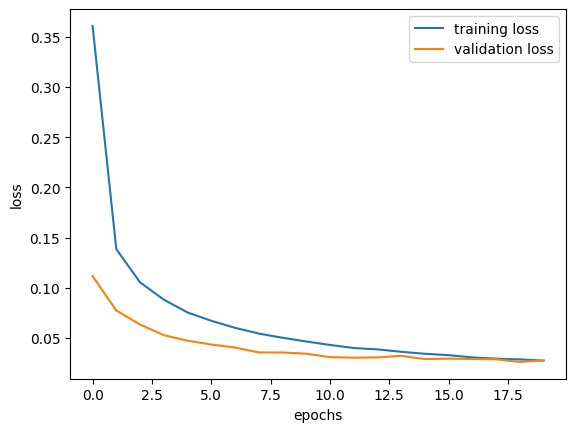

In [5]:
import datetime

net.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

history = net.fit(train_ds, validation_data=val_ds, epochs=20)

import matplotlib.pyplot as plt
plt.figure()
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

In [7]:
(x_train, y_train), (x_test, y_test) = pp.load_data(return_eval=True)

_ = net.fit(x_train, y_train, epochs=1)

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0575 - accuracy: 0.9857


In [8]:
net.evaluate(x_train, y_train), net.evaluate(x_test, y_test)

313/313 [==============================] - 0s 1ms/step - loss: 0.0220 - accuracy: 0.9934


([0.014097415842115879, 0.9956499934196472],
 [0.022037848830223083, 0.993399977684021])

In [9]:
pp.plot_confusion_matrix(x_test, y_test, net)

<tf.Tensor: shape=(10, 10), dtype=int32, numpy=
array([[ 975,    0,    0,    0,    2,    0,    2,    1,    0,    0],
       [   0, 1135,    0,    0,    0,    0,    0,    0,    0,    0],
       [   1,    1, 1025,    1,    1,    0,    1,    2,    0,    0],
       [   0,    0,    1, 1008,    0,    1,    0,    0,    0,    0],
       [   0,    0,    0,    0,  977,    0,    1,    0,    0,    4],
       [   0,    0,    0,    8,    0,  882,    2,    0,    0,    0],
       [   1,    1,    0,    0,    1,    3,  952,    0,    0,    0],
       [   0,    2,    3,    0,    0,    0,    0, 1020,    0,    3],
       [   0,    0,    1,    0,    0,    1,    0,    0,  972,    0],
       [   0,    1,    0,    4,   12,    3,    0,    1,    0,  988]],
      dtype=int32)>

In [10]:
net.evaluate(train_ds), net.evaluate(val_ds), net.evaluate(test_aug.batch(512))

118/118 [==============================] - 1s 10ms/step - loss: 0.1166 - accuracy: 0.9639


([0.10625182837247849, 0.9658518433570862],
 [0.11443411558866501, 0.9643148183822632],
 [0.11656025052070618, 0.9639000296592712])

In [11]:
net.save(modelp.joinpath("baseaug.h5").resolve().as_posix(), save_format="h5")